In [2]:
import psutil
import torch

# 获取系统的总内存和可用内存（以 MB 为单位）
mem = psutil.virtual_memory()
total_memory = mem.total / (1024 ** 2)  # MB
available_memory = mem.available / (1024 ** 2)  # MB

print(f"系统总内存: {total_memory:.2f} MB")
print(f"系统可用内存: {available_memory:.2f} MB")

# 检查 PyTorch 的 CPU 内存占用
if torch.cuda.is_available():
    gpu_mem = torch.cuda.memory_allocated() / (1024 ** 2)  # MB
    print(f"PyTorch 正在使用 GPU，已分配内存: {gpu_mem:.2f} MB")
else:
    # 获取当前进程的内存占用（以 MB 为单位）
    process = psutil.Process()
    process_memory = process.memory_info().rss / (1024 ** 2)  # MB
    print(f"PyTorch 进程占用的内存: {process_memory:.2f} MB")

系统总内存: 13872.33 MB
系统可用内存: 8410.93 MB
PyTorch 正在使用 GPU，已分配内存: 0.00 MB


In [3]:
import torch
import scipy.io as sio
from hamiltonians.Central import MZMVortexHamiltonian
from hamiltonians.Lead import SpinfulLead,SpinlessLead
from greens_functions.transport_calculation import calculate_transport_properties
from dataplot.ldos_plot import plot_ldos_surface, plot_ldos_energy_slice

funcDevice = 'cuda'

# System parameters from the paper
Ny = 4  # Larger system to see vortex effects
Nx = 4
t_y = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)
t_x = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)
mu = torch.tensor(0.6, dtype=torch.complex64, device=funcDevice)
B = torch.tensor(0.0, dtype=torch.complex64, device=funcDevice)
M = torch.tensor(0, dtype=torch.complex64, device=funcDevice)
Delta_0 = torch.tensor(0.2, dtype=torch.complex64, device=funcDevice)
xi_0 = torch.tensor(0.1, dtype=torch.float32, device=funcDevice)
lambda_L = torch.tensor(30.0, dtype=torch.float32, device=funcDevice)
temperature = torch.tensor(0, dtype=torch.float32, device=funcDevice)

# Define vortex positions (for example, two vortices)
# Scale vortex positions with system size
vortex1_x = round(Nx * 0.45) + 0.5  # 1/4 of system size
vortex1_y = round(Ny * 0.45) + 0.5
vortex2_x = round(Nx * 0.55) + 0.5  # 3/4 of system size
vortex2_y = round(Ny * 0.55) + 0.5

vortex_positions = [(vortex1_x, vortex1_y), (vortex2_x, vortex2_y)]  # Positions in lattice units
# Create Hamiltonian with vortices
vortex_hamiltonian = MZMVortexHamiltonian(
    Ny=Ny, 
    Nx=Nx, 
    t_y=t_y,
    t_x=t_x,
    Delta_0=Delta_0,
    xi_0=xi_0,
    lambda_L=lambda_L,
    vortex_positions=vortex_positions,
    mu=mu,
    B=B,
    M=M,
    boundary_condition='periodic'
)


ModuleNotFoundError: No module named 'scipy'

In [4]:

H_full_BdG = vortex_hamiltonian.H_full_BdG


In [7]:
# Create leads at vortex positions
leads_info = []

# Parameters for leads
mu_lead = torch.tensor(0, dtype=torch.float32, device=funcDevice)
lead_t = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)
t_lead_central = torch.tensor(1, dtype=torch.complex64, device=funcDevice)

# Add leads at each vortex position
for i, (vortex_x, vortex_y) in enumerate(vortex_positions):
    # Convert vortex position to nearest integer site
    site_x = int(round(vortex_x))
    site_y = int(round(vortex_y))
    
    # Set different mu for first lead vs others
    lead_mu = torch.tensor(10.0 if i == 0 else -10.0, dtype=torch.float32, device=funcDevice)
    
    # Create spinful lead
    lead = SpinfulLead(
        mu=lead_mu,
        t_lead=lead_t,
        connection_coordinates=[(site_x, site_y)],  # Single connection point
        central_Nx=Nx,
        central_Ny=Ny,
        device=funcDevice,
        temperature=temperature,
        t_lead_central=t_lead_central
    )
    
    # Add lead to leads_info
    leads_info.append(lead)

In [11]:
 
# Define energy grid for LDOS calculation
E_min, E_max = -1, 1  # Around the gap scale
num_points = 500
E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)
eta = torch.tensor(1e-2, dtype=torch.float32, device=funcDevice)

# Split energy points into chunks
chunk_size = 5  # Adjust chunk size based on memory constraints
num_chunks = (num_points + chunk_size - 1) // chunk_size
# Initialize lists to store results
all_ldos = []
all_rho_electron = []
all_rho_hole = []
all_transmission = []
all_andreev = []
all_current = []
all_noise = []
all_current_density = {direction: [] for direction in ['right', 'up', 'right2', 'up2']}

# Calculate transport properties in chunks
print("Calculating transport properties in chunks...")
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, num_points)
    E_chunk = E[start_idx:end_idx]
    
    print(f"Processing chunk {i+1}/{num_chunks} (E = {E_chunk[0]:.3f} to {E_chunk[-1]:.3f})")
    
    # Calculate transport properties for this chunk
    chunk_results = calculate_transport_properties(
        E_batch=E_chunk,
        H_total=H_full_BdG,
        leads_info=leads_info,
        temperature=temperature,
        eta=eta,
        method='direct',
        Nx=Nx,
        Ny=Ny,
        orb_num=2
    )
    
    all_ldos.append(chunk_results['rho_e_jj'])
    all_rho_electron.append(chunk_results['rho_electron'])
    all_rho_hole.append(chunk_results['rho_hole'])
    all_transmission.append(chunk_results['transmission'])
    all_andreev.append(chunk_results['andreev'])
    all_current.append(chunk_results['current'])
    all_noise.append(chunk_results['noise'])
    
    # Collect current density for each direction
    for direction in ['right', 'up', 'right2', 'up2']:
        all_current_density[direction].append(chunk_results['current_density'][direction])

# Combine results from all chunks
ldos = torch.cat(all_ldos, dim=0)

# Combine current density results
for direction in ['right', 'up', 'right2', 'up2']:
    all_current_density[direction] = torch.cat(all_current_density[direction], dim=0).detach().cpu().numpy()


Calculating transport properties in chunks...
Processing chunk 1/100 (E = -1.000 to -0.984)
Processing chunk 2/100 (E = -0.980 to -0.964)
Processing chunk 3/100 (E = -0.960 to -0.944)
Processing chunk 4/100 (E = -0.940 to -0.924)
Processing chunk 5/100 (E = -0.920 to -0.904)
Processing chunk 6/100 (E = -0.900 to -0.884)
Processing chunk 7/100 (E = -0.880 to -0.864)
Processing chunk 8/100 (E = -0.860 to -0.844)
Processing chunk 9/100 (E = -0.840 to -0.824)
Processing chunk 10/100 (E = -0.820 to -0.804)
Processing chunk 11/100 (E = -0.800 to -0.784)
Processing chunk 12/100 (E = -0.780 to -0.764)
Processing chunk 13/100 (E = -0.760 to -0.743)
Processing chunk 14/100 (E = -0.739 to -0.723)
Processing chunk 15/100 (E = -0.719 to -0.703)
Processing chunk 16/100 (E = -0.699 to -0.683)
Processing chunk 17/100 (E = -0.679 to -0.663)
Processing chunk 18/100 (E = -0.659 to -0.643)
Processing chunk 19/100 (E = -0.639 to -0.623)
Processing chunk 20/100 (E = -0.619 to -0.603)
Processing chunk 21/100

In [27]:
import datetime
# Get the current timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
import os
this_run_dir = f'vortex_Nx{Nx}_ty{t_y}_tx{t_x}_D{Delta_0}_xi{xi_0}_lam{lambda_L}_mu{mu}_{timestamp}'
os.makedirs(this_run_dir, exist_ok=True)


In [28]:

# Save results
sio.savemat(f'{this_run_dir}/vortex_ldos_Nx{Nx}_ty{t_y}_tx{t_x}_D{Delta_0}_xi{xi_0}_lam{lambda_L}_mu{mu}_B{B}_M{M}_{timestamp}.mat', {
    'ldos': ldos.detach().cpu().numpy(),
    'energy': E.detach().cpu().numpy(),
    'all_rho_electron': all_rho_electron,
    'H_full_BdG': H_full_BdG.detach().cpu().numpy(),
    'all_current_density': all_current_density
})


In [29]:
# import scipy.io as sio

# # Define the filename
# filename = 'vortex_ldos_Nx60_ty(1+0j)_tx(1+0j)_D(0.20000000298023224+0j)_xi0.10000000149011612_lam30.0_mu(0.6000000238418579+0j)_B0j_M0j.mat'

# # Load the data from the .mat file
# data = sio.loadmat(filename)

# # Extract the saved variables
# ldos = data['ldos']  # Load the LDOS data
# energy = data['energy']  # Load the energy data
# H_full_BdG = data['H_full_BdG']  # Load the full BdG Hamiltonian data

# # Print the loaded data to verify
# print("Loaded LDOS shape:", ldos.shape)
# print("Loaded energy shape:", energy.shape)
# print("Loaded H_full_BdG shape:", H_full_BdG.shape)

In [ ]:
import numpy as np

# Get the current density array
current_density = all_current_density['right2']

# Find positions of NaN values
nan_positions = np.argwhere(np.isnan(current_density))

# Print the positions
print("Positions of NaN values:")
print(nan_positions)



Positions of NaN values:
[]


In [31]:
# Import the functions from the new module
from dataplot.current_density_plot import (
    combine_current_densities,
    integrate_current_density,
    plot_integrated_current_density
)


combined_current_density = combine_current_densities(all_current_density)


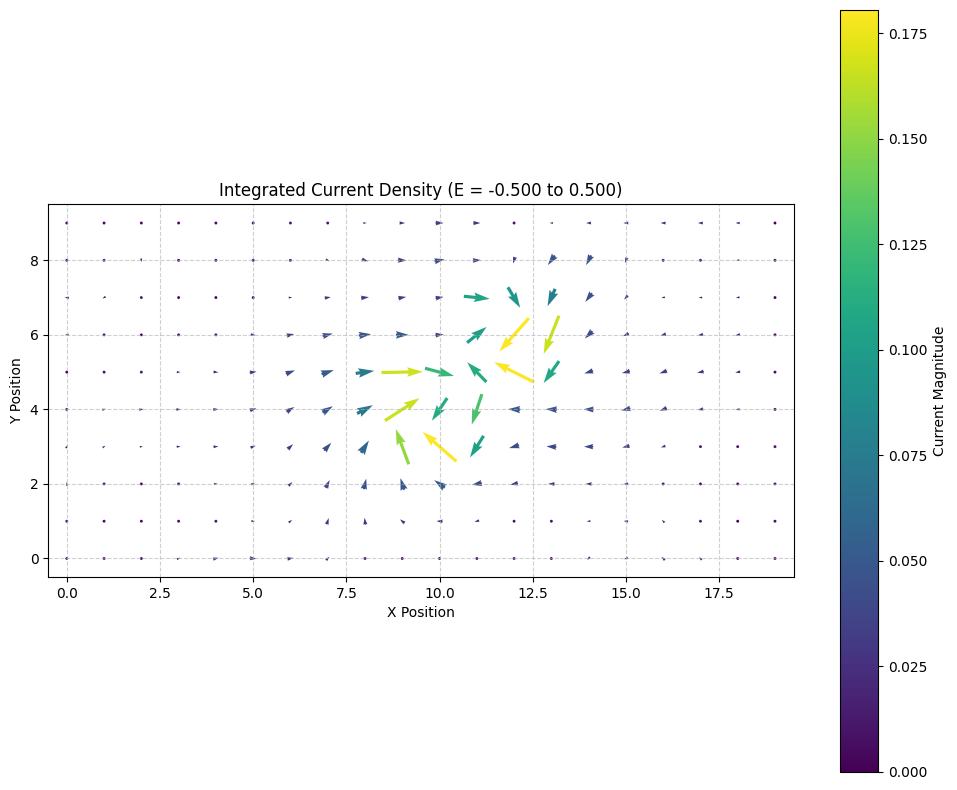

{'x': array([[ 2.68475339e-03, -3.59963393e-03,  7.13075278e-05,
          7.61146145e-03,  8.34210776e-03, -2.23055435e-03,
         -1.51738143e-02, -1.71689764e-02, -6.23518368e-03,
          9.97246476e-04],
        [ 5.02241310e-03, -4.30883188e-03,  6.78020529e-04,
          1.13075273e-02,  1.52515909e-02,  5.86919673e-03,
         -8.56484566e-03, -1.27587831e-02, -1.96268060e-03,
          3.24102608e-03],
        [ 7.62016419e-03, -2.80668098e-03,  2.57366430e-03,
          1.26524009e-02,  1.73757076e-02,  1.17061771e-02,
          8.48128810e-04, -4.29714005e-03,  2.38898536e-03,
          4.03588731e-03],
        [ 1.38934599e-02,  3.77545087e-03,  9.02233832e-03,
          1.61506906e-02,  1.88994277e-02,  1.53271137e-02,
          7.24365469e-03, -6.60837395e-06,  2.20158976e-03,
          4.13060095e-03],
        [ 2.23244336e-02,  1.15458844e-02,  1.51763111e-02,
          2.00569984e-02,  2.21848506e-02,  1.99552011e-02,
          1.19134402e-02,  7.99446309e-04, -3.3

In [ ]:

# Plot integrated current density for a specific energy window
plot_integrated_current_density(
    E_values=E,
    current_density=combined_current_density,
    E_lower=-0.5,  # Lower energy bound
    E_upper=0.5,   # Upper energy bound
    grid_spacing=1,
    arrow_scale=3,
    cmap='viridis',
)

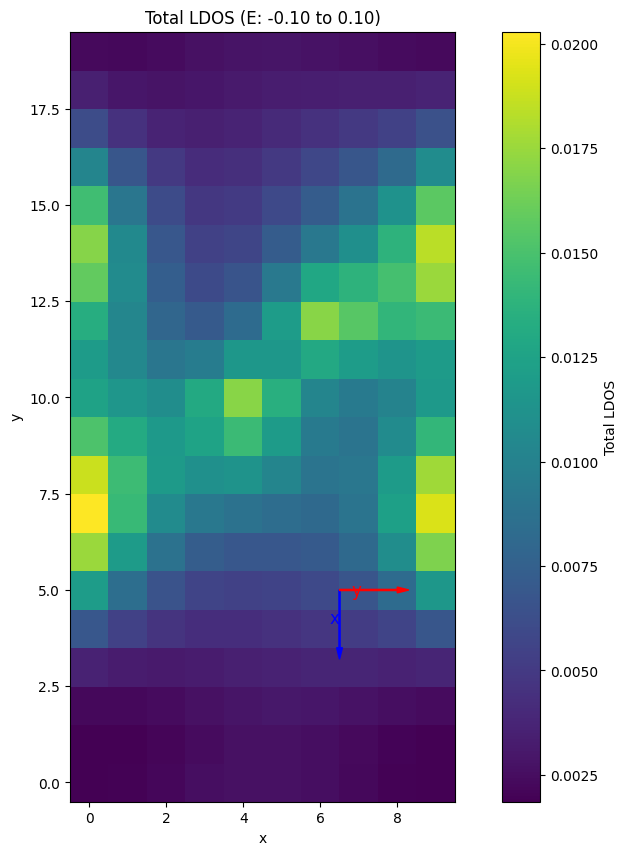

In [ ]:

# Plot LDOS
from dataplot.ldos_plot import plot_ldos_surface, plot_ldos_energy_slice

import datetime


# Plot LDOS surface at E=0 (zero energy)
plot_ldos_surface(
    E_values=E,
    rho_jj_values=ldos,
    E_lower=-0.1,
    E_upper=0.1,
    Nx=Nx,
    Ny=Ny,
    num_orbitals=2,  # spin case
    save_path=f'{this_run_dir}/ldos_surface_E0fvortex_ldos_Nx{Nx}_ty{t_y}_tx{t_x}_D{Delta_0}_xi{xi_0}_lam{lambda_L}_mu{mu}_eta{eta}_{timestamp}.png'
)

# # Plot LDOS at specific energies
# for energy in [0.0, 0.1, -0.1]:
#     plot_ldos_energy_slice(
#         E_values=E,
#         rho_jj_values=ldos,
#         energy=energy,
#         Nx=Nx,
#         Ny=Ny,
#         is_spin=True,
#         save_path=f'ldos_E_{energy:.2f}.png'
#     )

In [34]:
# After calculating results in chunks and combining them
all_rho_electron = torch.cat(all_rho_electron, dim=0)
all_rho_hole = torch.cat(all_rho_hole, dim=0)


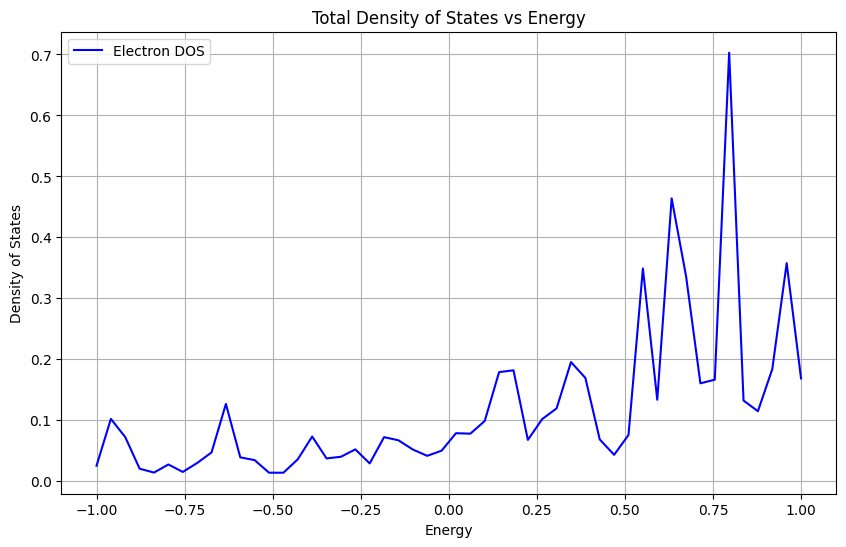

In [ ]:

# Plot total DOS
from dataplot.ldos_plot import plot_total_dos

plot_total_dos(
    E_values=E,
    rho_electron=all_rho_electron.reshape(-1) / (Nx * Ny),
    rho_hole=None,
    save_path=f'{this_run_dir}/total_dos.png'
)

In [ ]:
# Calculate the integrated DOS using trapezoidal rule
integrated_dos = torch.trapz(all_rho_electron, E)
print(f"Integrated DOS: {integrated_dos.item():.4f}")


Integrated DOS: 47.0534


In [37]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


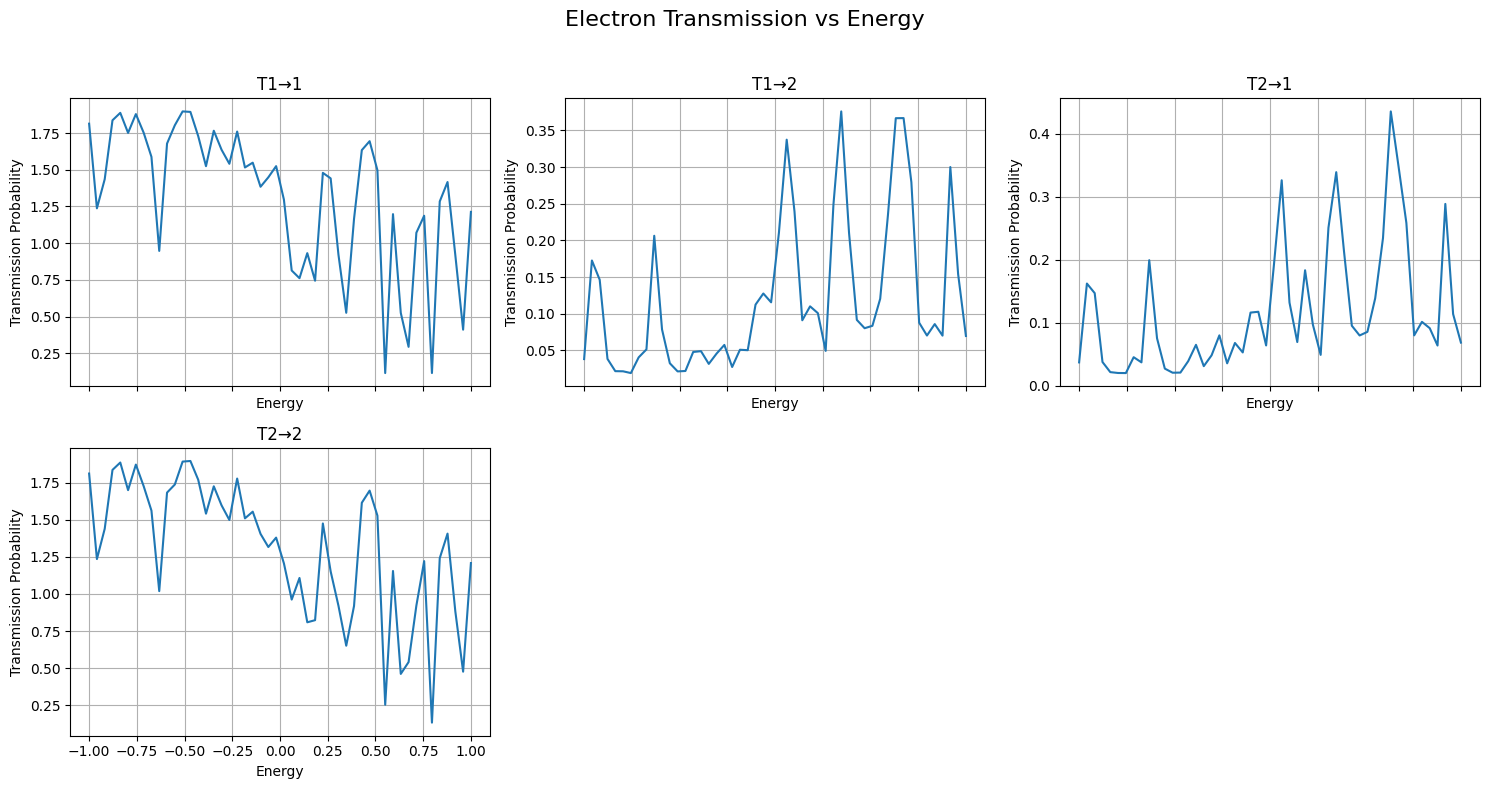

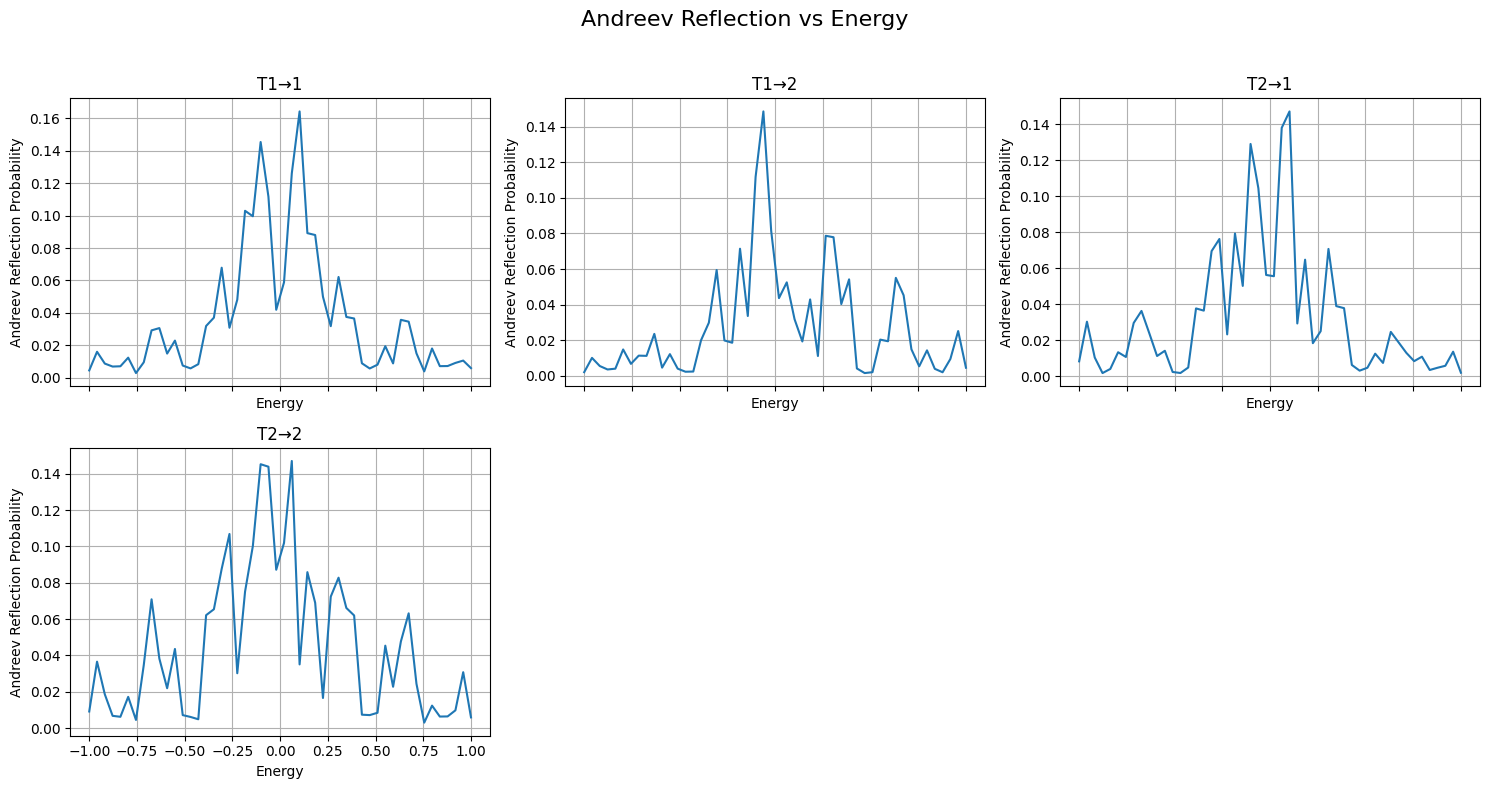

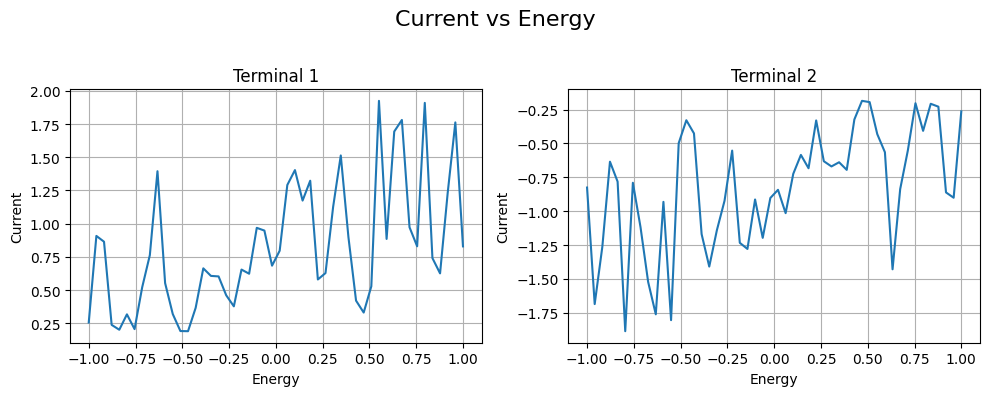

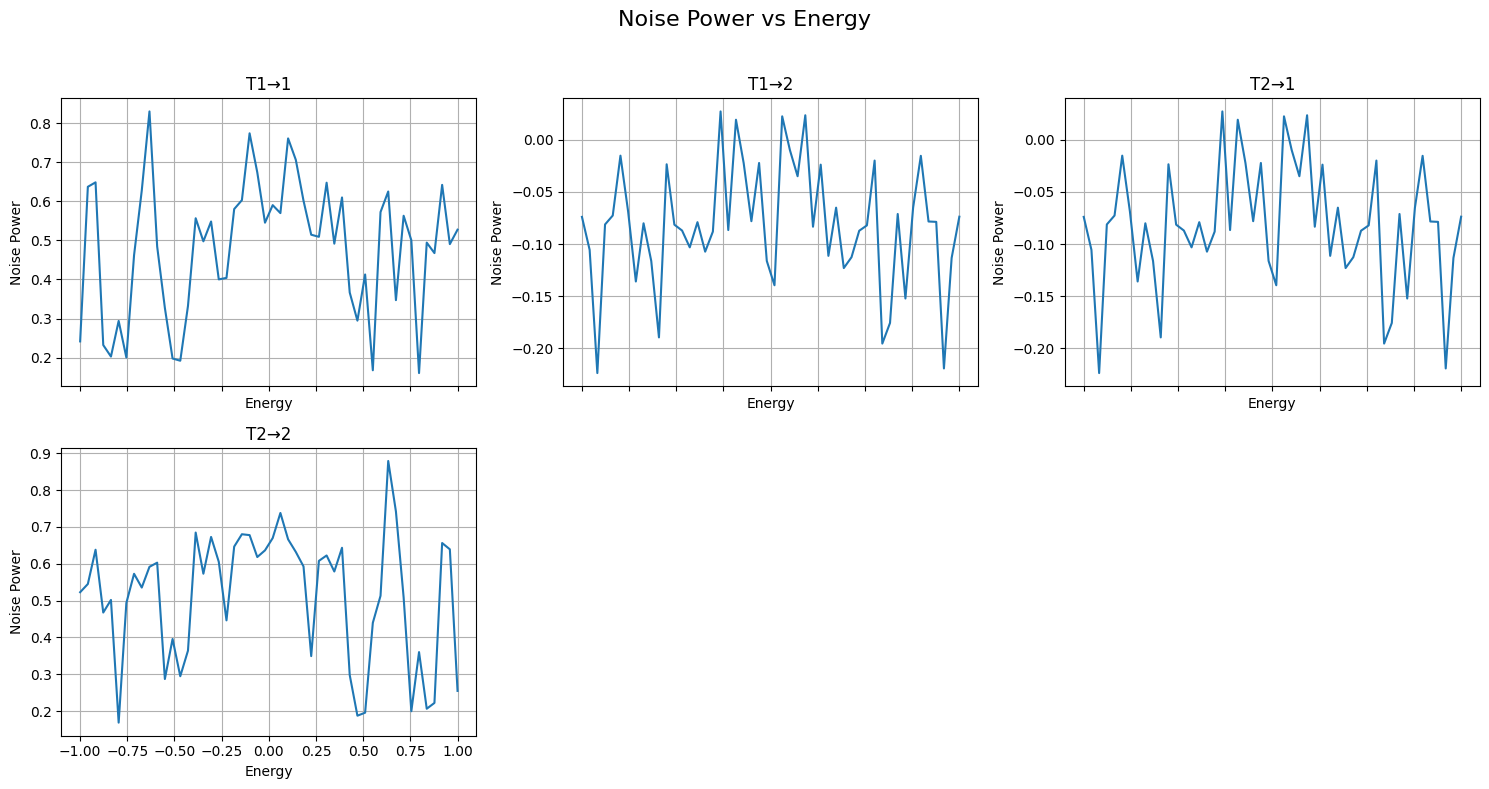

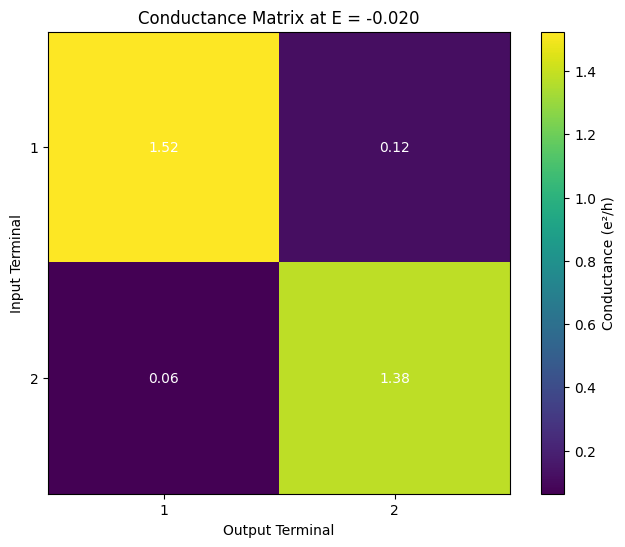

In [ ]:
# After calculating results
from dataplot.transport_plot import plot_all_transport_quantities, plot_conductance_matrix

# Combine all chunks
all_transmission = torch.cat(all_transmission, dim=0)
all_andreev = torch.cat(all_andreev, dim=0)
all_current = torch.cat(all_current, dim=0)
all_noise = torch.cat(all_noise, dim=0)

# Create transport data dictionary
transport_data = {
    'transmission': all_transmission,
    'andreev': all_andreev,
    'current': all_current,
    'noise': all_noise
}

# Plot all transport quantities
plot_all_transport_quantities(
    E_values=E,
    transport_data=transport_data,
    save_dir=f'{this_run_dir}/transport_plots'
)

# Plot conductance matrix at zero energy
plot_conductance_matrix(
    E_values=E,
    transport_data=transport_data,
    energy_point=0.0,
    save_path=f'{this_run_dir}/conductance_matrix_E0.png'
)

In [39]:
# vortex_positions=(torch.Tensor(15.5),torch.Tensor(15.5))
# Create the Hamiltonian
vortex_ham = MZMVortexHamiltonian(
    Ny=20, Nx=20,
    t_y=t_y, t_x=t_x,
    Delta_0=Delta_0,
    xi_0=xi_0,
    lambda_L=lambda_L,
    vortex_positions=vortex_positions,
    mu=mu, B=B, M=M
)

# Visualize fields
vortex_ham.visualize_vector_potential()
# vortex_ham.visualize_delta_field()
# vortex_ham.visualize_peierls_phase()